In [1]:
pip install ipython

Note: you may need to restart the kernel to use updated packages.


In [2]:
%matplotlib inline

In [3]:
from __future__ import print_function, division
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import numpy as np
import csv
import os
import tarfile
from urllib.parse import urlparse
from urllib.request import urlretrieve
import numpy as np
import torch
from torch.utils.data import Dataset
from PIL import Image
from tqdm import tqdm
from torch.utils.data import DataLoader
from torchvision import transforms
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
cudnn.benchmark = True
plt.ion()   # interactive mode

In [4]:
import os

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
!pip install -q livelossplot==0.3.3
!pip install -q ipython-autotime
%load_ext autotime

time: 645 µs (started: 2022-10-30 16:47:10 +00:00)


In [7]:
#helper function
def get_label(row):
  for c in labels.columns:
    if row[c]==1:
      return c

labels = pd.read_csv('../input/isiccsvfile/ISIC_2019_Training_GroundTruth.csv')
labels['l']=labels.apply(get_label, axis=1)
X=labels.drop(['l','UNK'], axis=1)
y = labels['l']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.21, random_state=42,stratify=y)
X_train['image'] = '../input/pp1isic/preprocessed-hair/'+X_train['image']+ '.jpg'
X_test['image'] = '../input/pp1isic/preprocessed-hair/'+X_test['image']+ '.jpg'
X_test.to_csv('validation.csv', index=False)
X_train.to_csv('training.csv', index=False)
train_path = 'training.csv'
class_path = 'validation_class.csv'
eval_path = 'validation.csv'
train_img_path = '../input/pp1isic/preprocessed-hair'


time: 1.14 s (started: 2022-10-30 16:47:10 +00:00)


In [8]:
class_names = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']

def read_object_labels_csv(file,phase, header=True):
    img_t=[]
    if phase == 'Train':
      dir = 'training.csv'
    elif phase == "Valid":
      dir = 'validation.csv'
    with open(dir, "r") as f:
        csvReader = csv.reader(f)
        next(csvReader, None)
        k=0
        for line in csvReader:
            k+=1
            image_name= line[0]
            label = line[1:9]
            label = torch.from_numpy(np.array(label, dtype=np.float64))
            item = (image_name,label)
            img_t.append(item)
    return img_t


class CHEXPERT(Dataset):
    def __init__(self, root, phase, csv_path,transform=None):
        self.root = os.path.abspath(root)
        self.phase = phase
        self.transform = transform
        self.path_images = self.root
        file_csv = pd.read_csv(csv_path)
        self.classes = class_names
        self.images = read_object_labels_csv(file_csv,phase)
        print('[dataset] classification phase={} number of classes={}  number of images={}'.format(phase, len(self.classes), len(self.images)))

    def __getitem__(self, index):
        filename, target = self.images[index]
        filename = filename
        img = Image.open(filename).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        
        data = {'image':img, 'target': target}
        return data

    def __len__(self):
        return len(self.images)

    def get_number_classes(self):
        return len(self.classes)


time: 2.08 ms (started: 2022-10-30 16:47:11 +00:00)


In [9]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
train_dataset = CHEXPERT(train_img_path, transform=data_transforms['train'], phase='Train',csv_path=train_path)
val_dataset = CHEXPERT(train_img_path, transform=data_transforms['val'],phase='Valid',csv_path=eval_path)

image_datasets ={'train': train_dataset, 'val': val_dataset}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,shuffle=False, num_workers=2)for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

[dataset] classification phase=Train number of classes=9  number of images=20011
[dataset] classification phase=Valid number of classes=9  number of images=5320
time: 293 ms (started: 2022-10-30 16:47:11 +00:00)


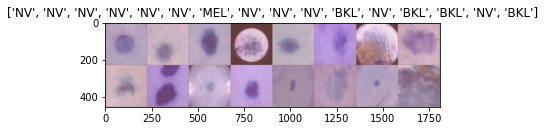

time: 1.11 s (started: 2022-10-30 16:47:11 +00:00)


In [10]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.6678, 0.5298, 0.5245])
    std = np.array([0.1333, 0.1476, 0.1590])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
data = next(iter(dataloaders['train']))
ps = data['target'].numpy()
l = np.where(ps==1.0)
l = l[1].astype(int)
# Make a grid from batch
out = torchvision.utils.make_grid(data['image'])
imshow(out, title=[class_names[x] for x in l])

In [11]:
model=models.vit_b_32(pretrained=False)
model.heads=nn.Sequential(nn.Linear(768, 8), nn.Sigmoid())
checkpoint = torch.load('../input/isic2019hairvit32b/resnet50_wt_epoch_9_batch_78_auc_0.6677.pt')
model.load_state_dict(checkpoint['model_state_dict'],strict=False)
del checkpoint
model.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (linear_1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (dropout_1): Dropout(p=0.0, inplace=False)
          (linear_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout_2): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
 

time: 12.4 s (started: 2022-10-30 16:47:12 +00:00)


In [12]:
class FusionMatrix(object):
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.matrix = np.zeros((self.num_classes, self.num_classes), dtype=int)

    def update(self, output, label):
        length = output.shape[0]
        for i in range(length):
            self.matrix[int(output[i]), int(label[i])] += 1

    def get_fusion_matrix(self):
        return self.matrix

    def get_rec_per_class(self):
        rec = np.array(
            [
                self.matrix[i, i] / self.matrix[:, i].sum()
                for i in range(self.num_classes)
            ]
        )
        rec[np.isnan(rec)] = 0
        return rec

    def get_pre_per_class(self):
        pre = np.array(
            [
                self.matrix[i, i] / self.matrix[i, :].sum()
                for i in range(self.num_classes)
            ]
        )
        pre[np.isnan(pre)] = 0
        return pre

    def get_accuracy(self):
        acc = (
            np.sum([self.matrix[i, i] for i in range(self.num_classes)])
            / self.matrix.sum()
        )
        return acc

    # convert multi-classification into binary classification tasks, and calculate the accuracy.
    def get_binary_accuracy(self, class_no):
        class_no = int(class_no)
        if class_no >= self.num_classes or class_no < 0:
            raise AttributeError(
                "Parameter class_no must less than the number of class.")

        error_num = 0
        for i in range(self.num_classes):
            error_num += self.matrix[i, class_no]
            error_num += self.matrix[class_no, i]
        error_num -= 2 * self.matrix[class_no, class_no]
        ok_num = self.matrix.sum() - error_num
        acc = ok_num / self.matrix.sum()
        return acc

    def get_balance_accuracy(self):
        rec = self.get_rec_per_class()
        bacc = np.mean(rec)
        return bacc

    def get_f1_score(self):
        recall = self.get_rec_per_class()
        precision = self.get_pre_per_class()
        f1_score = 2 * (precision * recall) / (precision + recall)
        f1_score[np.isnan(f1_score)] = 0
        return np.mean(f1_score)

    def plot_confusion_matrix(self, normalize = False, cmap=plt.cm.Blues):
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

        # Compute confusion matrix
        cm = self.matrix.T

        fig, ax = plt.subplots()
        im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
        ax.figure.colorbar(im, ax=ax)
        # We want to show all ticks...
        ax.set(xticks=np.arange(cm.shape[1]),
               yticks=np.arange(cm.shape[0]),
               # ... and label them with the respective list entries
               xticklabels=np.arange(self.num_classes), yticklabels=np.arange(self.num_classes),
               title=title,
               ylabel='True label',
               xlabel='Predicted label')

        # Rotate the tick labels and set their alignment.
        plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
                 rotation_mode="anchor")

        # Loop over data dimensions and create text annotations.
        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, format(cm[i, j], fmt),
                        ha="center", va="center",
                        color="white" if cm[i, j] > thresh else "black")
        fig.tight_layout()
        return fig

time: 3.51 ms (started: 2022-10-30 16:47:25 +00:00)


In [13]:
from tqdm._tqdm_notebook import tqdm_notebook
def compute_predictions(model):
    model.eval()
    fusion_matrix = FusionMatrix(8)
    pred_lst=[]
    gt_lst=[]
    for i, sample in enumerate(dataloaders['val']):    
        images=sample['image']
        labels=sample['target']
        del sample
        images = images.to(device)
        labels=labels.numpy()
        outputs=model(images)
        outputs=outputs.detach()
        outputs=outputs.cpu()
        outputs=outputs.numpy()
        pred_lst.append(outputs)
        gt_lst.append(labels)
        del labels, outputs, images

    pred_lst=np.concatenate(pred_lst, axis=0)
    gt_lst=np.concatenate(gt_lst, axis=0)
    pred_lst2 = np.argmax(pred_lst, axis=1)
    gt_lst2 = np.argmax(gt_lst, axis=1)
    fusion_matrix.update(pred_lst2, gt_lst2)
    print("sensitivity-"+str(fusion_matrix.get_rec_per_class()))
    print("specicivity-"+str(fusion_matrix.get_pre_per_class()))
    print("Balanced Accuracy")
    print(fusion_matrix.get_balance_accuracy())
    print("Confusion Matrix")
    print(fusion_matrix.plot_confusion_matrix())
    print("f1-score")
    print(fusion_matrix.get_f1_score())
    
    #roc_auc = get_roc_auc(pred_lst, gt_lst)
    #print(roc_auc)
    auc_lst=[]
    acc_lst=[]
    for k in range(0,8):
        tmp_gt=gt_lst[:, k]
        tmp_pred=pred_lst[:,k]
        tmp_acc=accuracy_score(tmp_gt, tmp_pred.round())
        acc_lst.append(tmp_acc)
        tmp_auc=roc_auc_score(tmp_gt, tmp_pred)
        auc_lst.append(tmp_auc)

    
    auc_lst=np.array(auc_lst)
    
    acc_lst=np.array(acc_lst)
    print("auc-list")
    print('\n')
    print(auc_lst)
    print("accuracy-list")
    print('\n')
    print(acc_lst)
    auc=np.mean(auc_lst)
    acc = np.mean(acc_lst)
    print("mean-auc"+str(auc))
    print("mean-auc"+str(acc))
    f1s=0.0
    return auc,acc,pred_lst,gt_lst

time: 3.06 ms (started: 2022-10-30 16:47:25 +00:00)


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  """Entry point for launching an IPython kernel.


sensitivity-[0.04736842 0.95857988 0.00573066 0.         0.         0.06
 0.01886792 0.02272727]
specicivity-[0.29032258 0.53531599 0.19047619 0.         0.         0.02112676
 0.01020408 0.05      ]
Balanced Accuracy
0.13915926987384986
Confusion Matrix
Figure(432x288)
f1-score
0.10691325556143691
auc-list


[0.58214031 0.70451933 0.56514781 0.57167667 0.52828651 0.41496395
 0.44028859 0.50495316]
accuracy-list


[0.66052632 0.54285714 0.80319549 0.85263158 0.81578947 0.84736842
 0.73984962 0.74868421]
mean-auc0.5389970398489747
mean-auc0.7513627819548871


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in long_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide


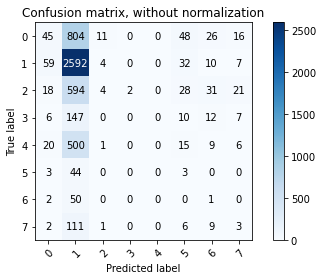

time: 32.7 s (started: 2022-10-30 16:47:25 +00:00)


In [14]:
auc1,acc1,pred_lst1,gt_lst1=compute_predictions(model)

In [15]:
model1=models.vit_b_32(pretrained=False)
model1.heads=nn.Sequential(nn.Linear(768, 8), nn.Sigmoid())
checkpoint = torch.load('../input/isic2019hairvit32b/resnet50_wt_epoch_13_batch_78_auc_0.6762.pt')
model1.load_state_dict(checkpoint['model_state_dict'],strict=False)
del checkpoint
model1.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (linear_1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (dropout_1): Dropout(p=0.0, inplace=False)
          (linear_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout_2): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
 

time: 8.49 s (started: 2022-10-30 16:47:58 +00:00)


sensitivity-[0.00210526 0.93602071 0.         0.         0.09618875 0.
 0.01886792 0.00757576]
specicivity-[0.33333333 0.55443593 0.         0.         0.09943715 0.
 0.0060241  0.02272727]
Balanced Accuracy
0.1325948003815654
Confusion Matrix
Figure(432x288)
f1-score
0.10235600380683832
auc-list


[0.55424304 0.73911271 0.52905873 0.58796235 0.52539693 0.49140038
 0.581721   0.55421456]
accuracy-list


[0.74398496 0.57199248 0.79906015 0.7193609  0.54661654 0.82368421
 0.8018797  0.74924812]
mean-auc0.5703887146712852
mean-auc0.7194783834586467


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in long_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide


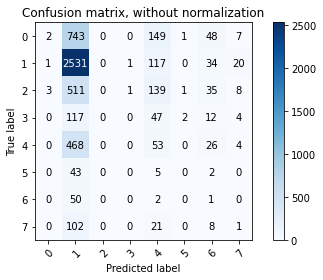

time: 17.6 s (started: 2022-10-30 16:48:06 +00:00)


In [16]:
auc1,acc1,pred_lst1,gt_lst1=compute_predictions(model1)

Computing Test Predictions


[0.58214031 0.70451933 0.56514781 0.57167667 0.52828651 0.41496395
 0.44028859 0.50495316]


[0.66052632 0.54285714 0.80319549 0.85263158 0.81578947 0.84736842
 0.73984962 0.74868421]
0.5389970398489747
0.7513627819548871


[0.55424304 0.73911271 0.52905873 0.58796235 0.52539693 0.49140038
 0.581721   0.55421456]


[0.74398496 0.57199248 0.79906015 0.7193609  0.54661654 0.82368421
 0.8018797  0.74924812]
0.5703887146712852
0.7194783834586467
auc-list


[0.57201204 0.73215211 0.5466205  0.58806394 0.52677132 0.45713852
 0.51311656 0.5289158 ]
accuracy-list


[0.70488722 0.55582707 0.80620301 0.80319549 0.70018797 0.85075188
 0.78026316 0.75676692]
mean-auc0.5580988475528748
mean-auc0.7447603383458646
sensitivity-[0.01473684 0.95636095 0.         0.         0.00725953 0.02
 0.03773585 0.        ]
specicivity-[0.4        0.53886226 0.         0.         0.09090909 0.03703704
 0.00533333 0.        ]
Balanced Accuracy
0.12951164575476257
Confusion Matrix
Figure(

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in long_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide


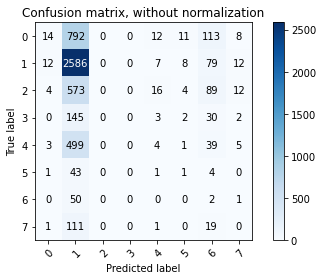

time: 34.1 s (started: 2022-10-30 16:48:24 +00:00)


In [17]:
from tqdm._tqdm_notebook import tqdm_notebook
def compute_predictions(model):
    model.eval()
    pred_lst4=[]
    gt_lst4=[]
    for i, sample in enumerate(dataloaders['val']):    
        images=sample['image']
        labels=sample['target']
        del sample
        images = images.to(device)
        labels=labels.numpy()
        outputs=model(images)
        outputs=outputs.detach()
        outputs=outputs.cpu()
        outputs=outputs.numpy()
        pred_lst4.append(outputs)
        gt_lst4.append(labels)
        del labels, outputs, images

    pred_lst=np.concatenate(pred_lst4, axis=0)
    gt_lst=np.concatenate(gt_lst4, axis=0)
    auc_lst=[]
    acc_lst=[]
    for k in range(0,8):
        tmp_gt=gt_lst[:, k]
        tmp_pred=pred_lst[:,k]
        tmp_acc=accuracy_score(tmp_gt, tmp_pred.round())
        acc_lst.append(tmp_acc)
        tmp_auc=roc_auc_score(tmp_gt, tmp_pred)
        auc_lst.append(tmp_auc)

    auc_lst=np.array(auc_lst)
    acc_lst=np.array(acc_lst)
    print('\n')
    print(auc_lst)
    print('\n')
    print(acc_lst)
    auc=np.mean(auc_lst)
    acc = np.mean(acc_lst)
    print(auc)
    print(acc)
    f1s=0.0
    return auc,acc,pred_lst,gt_lst

print('Computing Test Predictions')
auc1,acc1,pred_lst1,gt_lst1 = compute_predictions(model)
auc2,acc2,pred_lst2,gt_lst2 = compute_predictions(model1)

pred_lst = (pred_lst1+pred_lst2)/2
gt_lst = (gt_lst1+gt_lst2)/2
fusion_matrix = FusionMatrix(8)

auc_lst=[]
acc_lst=[]
for k in range(0,8):
    tmp_gt=gt_lst[:, k]
    tmp_pred=pred_lst[:,k]
    tmp_acc=accuracy_score(tmp_gt, tmp_pred.round())
    acc_lst.append(tmp_acc)
    tmp_auc=roc_auc_score(tmp_gt, tmp_pred)
    auc_lst.append(tmp_auc)


auc_lst=np.array(auc_lst)

acc_lst=np.array(acc_lst)
print("auc-list")
print('\n')
print(auc_lst)
print("accuracy-list")
print('\n')
print(acc_lst)
auc=np.mean(auc_lst)
acc = np.mean(acc_lst)
print("mean-auc"+str(auc))
print("mean-auc"+str(acc))

#pred_lst=np.concatenate(pred_lst, axis=0)
#gt_lst=np.concatenate(gt_lst, axis=0)
pred_lst2 = np.argmax(pred_lst, axis=1)
gt_lst2 = np.argmax(gt_lst, axis=1)
fusion_matrix.update(pred_lst2, gt_lst2)
print("sensitivity-"+str(fusion_matrix.get_rec_per_class()))
print("specicivity-"+str(fusion_matrix.get_pre_per_class()))
print("Balanced Accuracy")
print(fusion_matrix.get_balance_accuracy())
print("Confusion Matrix")
print(fusion_matrix.plot_confusion_matrix())
print("f1-score")
print(fusion_matrix.get_f1_score())

#roc_auc = get_roc_auc(pred_lst, gt_lst)
#print(roc_auc)


In [18]:
#helper function
def get_label(row):
  for c in labels.columns:
    if row[c]==1:
      return c

labels = pd.read_csv('../input/isiccsvfile/ISIC_2019_Training_GroundTruth.csv')
labels['l']=labels.apply(get_label, axis=1)
X=labels.drop(['l','UNK'], axis=1)
y = labels['l']
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.21, random_state=42,stratify=y)
X_train['image'] = '../input/pp2isic/preprocessed-segment/'+X_train['image']+ '.jpg'
X_test['image'] = '../input/pp2isic/preprocessed-segment/'+X_test['image']+ '.jpg'
X_test.to_csv('validation.csv', index=False)
X_train.to_csv('training.csv', index=False)
train_path = 'training.csv'
class_path = 'validation_class.csv'
eval_path = 'validation.csv'
train_img_path = '../input/pp2isic/preprocessed-segment'


time: 701 ms (started: 2022-10-30 16:48:58 +00:00)


In [19]:
class_names = ['MEL', 'NV', 'BCC', 'AK', 'BKL', 'DF', 'VASC', 'SCC', 'UNK']

def read_object_labels_csv(file,phase, header=True):
    img_t=[]
    if phase == 'Train':
      dir = 'training.csv'
    elif phase == "Valid":
      dir = 'validation.csv'
    with open(dir, "r") as f:
        csvReader = csv.reader(f)
        next(csvReader, None)
        k=0
        for line in csvReader:
            k+=1
            image_name= line[0]
            label = line[1:9]
            label = torch.from_numpy(np.array(label, dtype=np.float64))
            item = (image_name,label)
            img_t.append(item)
    return img_t


class CHEXPERT(Dataset):
    def __init__(self, root, phase, csv_path,transform=None):
        self.root = os.path.abspath(root)
        self.phase = phase
        self.transform = transform
        self.path_images = self.root
        file_csv = pd.read_csv(csv_path)
        self.classes = class_names
        self.images = read_object_labels_csv(file_csv,phase)
        print('[dataset] classification phase={} number of classes={}  number of images={}'.format(phase, len(self.classes), len(self.images)))

    def __getitem__(self, index):
        filename, target = self.images[index]
        filename = filename
        img = Image.open(filename).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        
        data = {'image':img, 'target': target}
        return data

    def __len__(self):
        return len(self.images)

    def get_number_classes(self):
        return len(self.classes)


time: 2.5 ms (started: 2022-10-30 16:48:59 +00:00)


In [20]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}
train_dataset = CHEXPERT(train_img_path, transform=data_transforms['train'], phase='Train',csv_path=train_path)
val_dataset = CHEXPERT(train_img_path, transform=data_transforms['val'],phase='Valid',csv_path=eval_path)

image_datasets ={'train': train_dataset, 'val': val_dataset}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,shuffle=False, num_workers=2)for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

[dataset] classification phase=Train number of classes=9  number of images=20011
[dataset] classification phase=Valid number of classes=9  number of images=5320
time: 337 ms (started: 2022-10-30 16:48:59 +00:00)


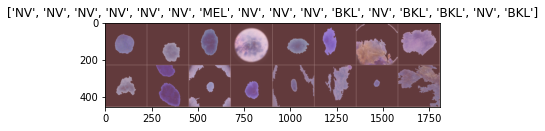

time: 861 ms (started: 2022-10-30 16:48:59 +00:00)


In [21]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.6678, 0.5298, 0.5245])
    std = np.array([0.1333, 0.1476, 0.1590])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
data = next(iter(dataloaders['train']))
ps = data['target'].numpy()
l = np.where(ps==1.0)
l = l[1].astype(int)
# Make a grid from batch
out = torchvision.utils.make_grid(data['image'])
imshow(out, title=[class_names[x] for x in l])

In [22]:
from tqdm._tqdm_notebook import tqdm_notebook
def compute_predictions(model):
    model.eval()
    fusion_matrix = FusionMatrix(8)
    pred_lst=[]
    gt_lst=[]
    for i, sample in enumerate(dataloaders['val']):    
        images=sample['image']
        labels=sample['target']
        del sample
        images = images.to(device)
        labels=labels.numpy()
        outputs=model(images)
        outputs=outputs.detach()
        outputs=outputs.cpu()
        outputs=outputs.numpy()
        pred_lst.append(outputs)
        gt_lst.append(labels)
        del labels, outputs, images

    pred_lst=np.concatenate(pred_lst, axis=0)
    gt_lst=np.concatenate(gt_lst, axis=0)
    pred_lst2 = np.argmax(pred_lst, axis=1)
    gt_lst2 = np.argmax(gt_lst, axis=1)
    fusion_matrix.update(pred_lst2, gt_lst2)
    print("sensitivity-"+str(fusion_matrix.get_rec_per_class()))
    print("specicivity-"+str(fusion_matrix.get_pre_per_class()))
    print("Balanced Accuracy")
    print(fusion_matrix.get_balance_accuracy())
    print("Confusion Matrix")
    print(fusion_matrix.plot_confusion_matrix())
    print("f1-score")
    print(fusion_matrix.get_f1_score())
    
    #roc_auc = get_roc_auc(pred_lst, gt_lst)
    #print(roc_auc)
    auc_lst=[]
    acc_lst=[]
    for k in range(0,8):
        tmp_gt=gt_lst[:, k]
        tmp_pred=pred_lst[:,k]
        tmp_acc=accuracy_score(tmp_gt, tmp_pred.round())
        acc_lst.append(tmp_acc)
        tmp_auc=roc_auc_score(tmp_gt, tmp_pred)
        auc_lst.append(tmp_auc)

    
    auc_lst=np.array(auc_lst)
    
    acc_lst=np.array(acc_lst)
    print("auc-list")
    print('\n')
    print(auc_lst)
    print("accuracy-list")
    print('\n')
    print(acc_lst)
    auc=np.mean(auc_lst)
    acc = np.mean(acc_lst)
    print("mean-auc"+str(auc))
    print("mean-auc"+str(acc))
    f1s=0.0
    return auc,acc,pred_lst,gt_lst

time: 2.38 ms (started: 2022-10-30 16:49:00 +00:00)


In [23]:
model=models.vit_b_32(pretrained=False)
model.heads=nn.Sequential(nn.Linear(768, 8), nn.Sigmoid())
checkpoint = torch.load('../input/isic2019hairvit32b/resnet50_wt_epoch_9_batch_78_auc_0.6677.pt')
model.load_state_dict(checkpoint['model_state_dict'],strict=False)
del checkpoint
model.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (linear_1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (dropout_1): Dropout(p=0.0, inplace=False)
          (linear_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout_2): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
 

time: 2.27 s (started: 2022-10-30 16:49:00 +00:00)


sensitivity-[0.14736842 0.00406805 0.02292264 0.08791209 0.00181488 0.04
 0.73584906 0.00757576]
specicivity-[0.22364217 0.23404255 0.22222222 0.02597403 0.125      0.02352941
 0.01020675 0.02222222]
Balanced Accuracy
0.13093886107716857
Confusion Matrix
Figure(432x288)
f1-score
0.04149523364349481
auc-list


[0.44542539 0.41592024 0.51583463 0.42882862 0.4820974  0.35680835
 0.69687732 0.38883583]
accuracy-list


[0.18007519 0.45545113 0.1362782  0.03966165 0.11052632 0.02030075
 0.01992481 0.03157895]
mean-auc0.4663284718739149
mean-auc0.12422462406015039


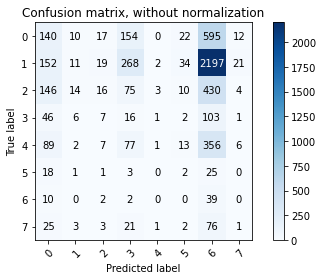

time: 25.4 s (started: 2022-10-30 16:49:02 +00:00)


In [24]:
auc1,acc1,pred_lst1,gt_lst1=compute_predictions(model)

In [25]:
model1=models.vit_b_32(pretrained=False)
model1.heads=nn.Sequential(nn.Linear(768, 8), nn.Sigmoid())
checkpoint = torch.load('../input/isic2019hairvit32b/resnet50_wt_epoch_13_batch_78_auc_0.6762.pt')
model1.load_state_dict(checkpoint['model_state_dict'],strict=False)
del checkpoint
model1.to(device)

VisionTransformer(
  (conv_proj): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32))
  (encoder): Encoder(
    (dropout): Dropout(p=0.0, inplace=False)
    (layers): Sequential(
      (encoder_layer_0): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (self_attention): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
        (dropout): Dropout(p=0.0, inplace=False)
        (ln_2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
        (mlp): MLPBlock(
          (linear_1): Linear(in_features=768, out_features=3072, bias=True)
          (act): GELU()
          (dropout_1): Dropout(p=0.0, inplace=False)
          (linear_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout_2): Dropout(p=0.0, inplace=False)
        )
      )
      (encoder_layer_1): EncoderBlock(
        (ln_1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
 

time: 2 s (started: 2022-10-30 16:49:28 +00:00)


sensitivity-[0.64421053 0.00073964 0.25358166 0.00549451 0.         0.
 0.         0.06060606]
specicivity-[0.19239233 0.16666667 0.24964739 0.03571429 0.         0.
 0.         0.00856531]
Balanced Accuracy
0.12057904990973589
Confusion Matrix
Figure(432x288)
f1-score
0.07173767348184425


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in long_scalars
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide


auc-list


[0.44581513 0.38596992 0.48500878 0.43788952 0.47460193 0.33164326
 0.8044338  0.35447916]
accuracy-list


[0.18966165 0.48383459 0.17575188 0.12857143 0.15488722 0.06616541
 0.08796992 0.0693609 ]
mean-auc0.4649801877737454
mean-auc0.16952537593984962


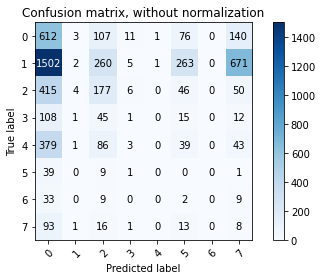

time: 16.5 s (started: 2022-10-30 16:49:30 +00:00)


In [26]:
auc1,acc1,pred_lst1,gt_lst1=compute_predictions(model1)

In [27]:
from tqdm._tqdm_notebook import tqdm_notebook
def compute_predictions(model):
    model.eval()
    pred_lst4=[]
    gt_lst4=[]
    for i, sample in enumerate(dataloaders['val']):    
        images=sample['image']
        labels=sample['target']
        del sample
        images = images.to(device)
        labels=labels.numpy()
        outputs=model(images)
        outputs=outputs.detach()
        outputs=outputs.cpu()
        outputs=outputs.numpy()
        pred_lst4.append(outputs)
        gt_lst4.append(labels)
        del labels, outputs, images

    pred_lst=np.concatenate(pred_lst4, axis=0)
    gt_lst=np.concatenate(gt_lst4, axis=0)
    auc_lst=[]
    acc_lst=[]
    for k in range(0,8):
        tmp_gt=gt_lst[:, k]
        tmp_pred=pred_lst[:,k]
        tmp_acc=accuracy_score(tmp_gt, tmp_pred.round())
        acc_lst.append(tmp_acc)
        tmp_auc=roc_auc_score(tmp_gt, tmp_pred)
        auc_lst.append(tmp_auc)

    auc_lst=np.array(auc_lst)
    acc_lst=np.array(acc_lst)
    print('\n')
    print(auc_lst)
    print('\n')
    print(acc_lst)
    auc=np.mean(auc_lst)
    acc = np.mean(acc_lst)
    print(auc)
    print(acc)
    f1s=0.0
    return auc,acc,pred_lst,gt_lst

time: 2.63 ms (started: 2022-10-30 16:49:46 +00:00)


In [28]:
print('Computing Test Predictions')
auc1,acc1,pred_lst1,gt_lst1 = compute_predictions(model)
auc2,acc2,pred_lst2,gt_lst2 = compute_predictions(model1)

Computing Test Predictions


[0.44542539 0.41592024 0.51583463 0.42882862 0.4820974  0.35680835
 0.69687732 0.38883583]


[0.18007519 0.45545113 0.1362782  0.03966165 0.11052632 0.02030075
 0.01992481 0.03157895]
0.4663284718739149
0.12422462406015039


[0.44581513 0.38596992 0.48500878 0.43788952 0.47460193 0.33164326
 0.8044338  0.35447916]


[0.18966165 0.48383459 0.17575188 0.12857143 0.15488722 0.06616541
 0.08796992 0.0693609 ]
0.4649801877737454
0.16952537593984962
time: 32.2 s (started: 2022-10-30 16:49:46 +00:00)


auc-list


[0.44278466 0.39372127 0.49465277 0.42903822 0.47478193 0.34669829
 0.79311555 0.36676786]
accuracy-list


[0.18308271 0.47255639 0.15319549 0.05620301 0.12575188 0.03947368
 0.03984962 0.04398496]
mean-auc0.46769506917768144
mean-auc0.1392622180451128
sensitivity-[0.85473684 0.00147929 0.23065903 0.00549451 0.         0.
 0.         0.01515152]
specicivity-[0.18226712 0.21052632 0.25801282 0.05882353 0.         0.
 0.         0.01136364]
Balanced Accuracy
0.13844014731000973
Confusion Matrix


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:28: RuntimeWarning: invalid value encountered in long_scalars


Figure(432x288)
f1-score
0.07125101037386575


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: invalid value encountered in true_divide


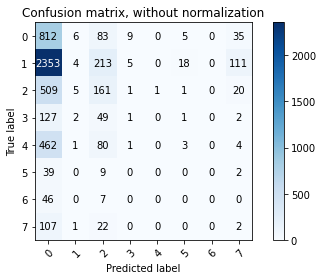

time: 743 ms (started: 2022-10-30 16:50:19 +00:00)


In [29]:
pred_lst = (pred_lst1+pred_lst2)/2
gt_lst = (gt_lst1+gt_lst2)/2
fusion_matrix = FusionMatrix(8)

auc_lst=[]
acc_lst=[]
for k in range(0,8):
    tmp_gt=gt_lst[:, k]
    tmp_pred=pred_lst[:,k]
    tmp_acc=accuracy_score(tmp_gt, tmp_pred.round())
    acc_lst.append(tmp_acc)
    tmp_auc=roc_auc_score(tmp_gt, tmp_pred)
    auc_lst.append(tmp_auc)


auc_lst=np.array(auc_lst)

acc_lst=np.array(acc_lst)
print("auc-list")
print('\n')
print(auc_lst)
print("accuracy-list")
print('\n')
print(acc_lst)
auc=np.mean(auc_lst)
acc = np.mean(acc_lst)
print("mean-auc"+str(auc))
print("mean-auc"+str(acc))

#pred_lst=np.concatenate(pred_lst, axis=0)
#gt_lst=np.concatenate(gt_lst, axis=0)
pred_lst2 = np.argmax(pred_lst, axis=1)
gt_lst2 = np.argmax(gt_lst, axis=1)
fusion_matrix.update(pred_lst2, gt_lst2)
print("sensitivity-"+str(fusion_matrix.get_rec_per_class()))
print("specicivity-"+str(fusion_matrix.get_pre_per_class()))
print("Balanced Accuracy")
print(fusion_matrix.get_balance_accuracy())
print("Confusion Matrix")
print(fusion_matrix.plot_confusion_matrix())
print("f1-score")
print(fusion_matrix.get_f1_score())

#roc_auc = get_roc_auc(pred_lst, gt_lst)
#print(roc_auc)
